In [61]:
# note: same thing for REPL
# note: we use this instead of magic because `black` will otherwise fail to format
#
# Enable autoreload to automatically reload modules when they change

from IPython import get_ipython

# do this so that formatter not messed up
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Import commonly used libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# graphics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# type annotation
import jaxtyping
from jaxtyping import Float, Int, jaxtyped
from typeguard import typechecked as typechecker

# more itertools
import more_itertools as mi

# itertools
import itertools
import collections

# tensor manipulation
import einops

import transformer_lens

# automatically apply jaxtyping
# %load_ext jaxtyping
# %jaxtyping.typechecker typeguard.typechecked

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# From:
#
# https://arena3-chapter1-transformer-interp.streamlit.app/[1.5.1]_Balanced_Bracket_Classifier

# What's the main difference from GPT-2 style architecture?

Choice of attention:

- GPT uses **`causal attention`**, where attention scores are **masked** if the source token comes after the destination token.
- This means **information can only flow forwards** in a GPT model, never backwards.
- The forward-only flow allows **parallel training** of GPT models.
- GPT's output is a series of **distributions over the next token**, each using only information from previous tokens.
- This model uses **`bidirectional attention`**, where attention scores **aren't masked** based on token positions.
- In this model, **information can flow in both directions**.
- This allows the model to use **information from the future** to predict the past.

# What are we predicting?

* GPT is trained via gradient descent on the cross-entropy loss between its predictions for the next token and the actual next tokens. 
* Models designed to perform classification are trained in a very similar way, but instead of outputting probability distributions over the next token, they output a distribution over class labels. 
* We do this by:
  * having an unembedding matrix of size `[d_model, num_classifications]`
  * only using a single sequence position (usually the 0th position) to represent our classification probabilities

* For each bracket sequence, our (important) output is a vector of two values: `(l0, l1)`
  * representing the model's logit distribution over (unbalanced, balanced). 
  * Our model was trained by minimizing the cross-entropy loss between these logits and the true labels.
  
Interestingly, since **logits** are **translation invariant**
* the only value we actually care about is the **difference between our logits**, `l0 - l1`. 
* This is the model's log likelihood ratio of the sequence being unbalanced vs balanced. 
* Later on, we'll be able to use this logit_diff to perform logit attribution in our model.
  

# How do we deal with varying lengths?

* After all, during training we need to have all sequences be of the same length so we can batch them together
* The model manages this via two new tokens: the `end` token and the `padding` token.
  * The `end` token goes at the end of every bracket sequence
  * then we add `padding` tokens to the end until the sequence is up to some fixed length.
* The model learns to ignore these `padding` tokens when making predictions.

For instance:
* this model was trained on bracket sequences of up to length 40
* so if we wanted to classify the bracket string `(())` then we would pad it to the length-42 sequence:
```
[start] + ( + ( + ) + ) + [end] + [pad] + [pad] + ... + [pad]
```

* When we calculate the attention scores, **we mask them at all (`query`, `key`) positions where the `key` is a `padding` token**.
* This makes sure that information doesn't flow from `padding` tokens to other tokens in the sequence (just like how GPT's causal masking makes sure that information doesn't flow from future tokens to past tokens)

TODO(bschoen): Why wouldn't we let the model store information in those positions?

* Note that the attention scores aren't masked when the `query` is a ``padding`` token and the key isn't.
  * In theory, this means that information can be stored in the ``padding`` token positions.
  * However, because the ``padding`` token key positions are always masked, this information can't flow back into the rest of the sequence
    * so it never affects the final output.
* (Also, note that if we masked `query` positions as well, we'd get numerical errors, since we'd be taking softmax across a row where every element is minus infinity, which is not well-defined!)

> note: this is how BERT works


# Architecture

* Positional embeddings are sinusoidal (non-learned).
* It has hidden_size (aka `d_model`, aka `embed_dim`) of 56.
* It has bidirectional attention, like BERT.
* It has 3 attention layers and 3 MLPs.
* Each attention layer has two heads, and each head has headsize (aka `d_head`) of `hidden_size / num_heads = 28`.
* The MLP hidden layer has 56 neurons (i.e. its linear layers are square matrices).
* The input of each attention layer and each MLP is first layernormed, like in GPT.
* There's a LayerNorm on the residual stream after all the attention layers and MLPs have been added into it (this is also like GPT).
* Our embedding matrix `W_E` has five rows: one for each of the tokens `[start]`, `[pad]`, `[end]`, `(`, and `)` (in that order).
* Our unembedding matrix `W_U` has two columns: one for each of the classes unbalanced and balanced (in that order).
* When running our model, we get output of shape `[batch, seq_len, 2]`, and we then take the `[:, 0, :]` slice to get the output for the `[start]` token (i.e. the classification logits).
* We can then softmax to get our classification probabilities.
* Activation function is ReLU.
* To refer to attention heads, we'll again use the shorthand `layer.head` where both layer and head are zero-indexed
  * So `2.1` is the second attention head (index 1) in the third layer (index 2).

In [63]:
VOCAB = "()"

device = transformer_lens.utils.get_device()


def make_model_config() -> transformer_lens.HookedTransformerConfig:

    cfg = transformer_lens.HookedTransformerConfig(
        n_ctx=42,
        d_model=56,
        d_head=28,
        n_heads=2,
        d_mlp=56,
        n_layers=3,
        attention_dir="bidirectional",  # defaults to "causal"
        act_fn="relu",
        d_vocab=len(VOCAB) + 3,  # plus 3 because of end and pad and start token
        d_vocab_out=2,  # 2 because we're doing binary classification
        use_attn_result=True,
        device=device,
        use_hook_tokens=True,
    )

    return cfg

## Collate

In [64]:
def add_perma_hooks_to_mask_pad_tokens(
    model: transformer_lens.HookedTransformer,
    pad_token: int,
) -> transformer_lens.HookedTransformer:

    # Hook which operates on the tokens, and stores a mask where tokens equal [pad]
    def cache_padding_tokens_mask(
        tokens: Float[torch.Tensor, "batch seq"],
        hook: transformer_lens.hook_points.HookPoint,
    ) -> None:
        hook.ctx["padding_tokens_mask"] = einops.rearrange(tokens == pad_token, "b sK -> b 1 1 sK")

    # Apply masking, by referencing the mask stored in the `hook_tokens` hook context
    def apply_padding_tokens_mask(
        attn_scores: Float[torch.Tensor, "batch head seq_Q seq_K"],
        hook: transformer_lens.hook_points.HookPoint,
    ) -> None:
        attn_scores.masked_fill_(model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"], -1e5)
        if hook.layer() == model.cfg.n_layers - 1:
            del model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"]

    # Add these hooks as permanent hooks (i.e. they aren't removed after functions like run_with_hooks)
    for name, hook in model.hook_dict.items():
        if name == "hook_tokens":
            hook.add_perma_hook(cache_padding_tokens_mask)
        elif name.endswith("attn_scores"):
            hook.add_perma_hook(apply_padding_tokens_mask)

    return model

## Tokenizer

In [65]:
from jaxtyping import Int


class SimpleTokenizer:
    """
    Here we copy from ARENA_3.0/chapter1_transformer_interp/exercises/part51_balanced_bracket_classifier/brackets_datasets.py

    Note:
        We leave this unchanged to minimize troubleshooting the tokenizer
    """

    START_TOKEN = 0
    PAD_TOKEN = 1
    END_TOKEN = 2
    base_d = {"[start]": START_TOKEN, "[pad]": PAD_TOKEN, "[end]": END_TOKEN}

    def __init__(self, alphabet: str) -> None:
        self.alphabet = alphabet
        # the 3 is because there are 3 special tokens (defined just above)
        self.t_to_i = {**{c: i + 3 for i, c in enumerate(alphabet)}, **self.base_d}
        self.i_to_t = {i: c for c, i in self.t_to_i.items()}

    def tokenize(
        self,
        strs: list[str] | str,
        max_len: int | None = None,
    ) -> Int[torch.Tensor, "batch seq"]:
        def c_to_int(c: str) -> int:
            if c in self.t_to_i:
                return self.t_to_i[c]
            else:
                raise ValueError(c)

        if isinstance(strs, str):
            strs = [strs]

        if max_len is None:
            max_len = max((max(len(s) for s in strs), 1))

        ints = [
            [self.START_TOKEN]
            + [c_to_int(c) for c in s]
            + [self.END_TOKEN]
            + [self.PAD_TOKEN] * (max_len - len(s))
            for s in strs
        ]
        return torch.tensor(ints)

    def decode(self, tokens: Int[torch.Tensor, "batch seq"]) -> list[str]:
        assert tokens.ndim >= 2, "Need to have a batch dimension"

        def int_to_c(c: int) -> str:
            if c < len(self.i_to_t):
                return self.i_to_t[c]
            else:
                raise ValueError(c)

        return [
            "".join(
                int_to_c(i.item()) for i in seq[1:] if i != self.PAD_TOKEN and i != self.END_TOKEN
            )
            for seq in tokens
        ]

    def __repr__(self) -> str:
        return f"SimpleTokenizer({self.alphabet!r})"

In [66]:
tokenizer = SimpleTokenizer("()")

# Examples of tokenization
# (the second one applies padding, since the sequences are of different lengths)
print(tokenizer.tokenize("()"))
print(tokenizer.tokenize(["()", "()()"]))

# Dictionaries mapping indices to tokens and vice versa
print(tokenizer.i_to_t)
print(tokenizer.t_to_i)

# Examples of decoding (all padding tokens are removed)
print(tokenizer.decode(torch.tensor([[0, 3, 4, 2, 1, 1]])))

tensor([[0, 3, 4, 2]])
tensor([[0, 3, 4, 2, 1, 1],
        [0, 3, 4, 3, 4, 2]])
{3: '(', 4: ')', 0: '[start]', 1: '[pad]', 2: '[end]'}
{'(': 3, ')': 4, '[start]': 0, '[pad]': 1, '[end]': 2}
['()']


## Make Model

In [67]:
def create_model(
    cfg: transformer_lens.HookedTransformerConfig, tokenizer: SimpleTokenizer
) -> transformer_lens.HookedTransformer:

    # create model
    model = transformer_lens.HookedTransformer(cfg)

    # add hooks for dealing with padding horror
    model.reset_hooks(including_permanent=True)
    model = add_perma_hooks_to_mask_pad_tokens(model, tokenizer.PAD_TOKEN)

    # move to device
    model = model.to(device)

    return model

# Sample Generation

In [68]:
import dataclasses
from typing import Iterator, Optional, List
import random


@dataclasses.dataclass(frozen=True)
class Sample:
    string: str  # Example: '(', '()))((', '((()' etc.
    is_balanced: bool  # True if the parentheses are balanced, False otherwise


def _is_balanced_parentheses(s: str) -> bool:
    """
    Check if the parentheses in the string are balanced.

    Args:
        s (str): The string containing parentheses.

    Returns:
        bool: True if balanced, False otherwise.
    """
    balance = 0
    for char in s:
        if char == "(":
            balance += 1
        elif char == ")":
            balance -= 1
            if balance < 0:
                return False  # A closing parenthesis without a matching opening
    return balance == 0


def generate_parenthesis_samples(max_length: int) -> Iterator[Sample]:
    """
    Generate random strings of '(' and ')' up to max_length in random order.
    For each string, determine if it is balanced.

    Args:
        max_length (int): The maximum length of the parentheses strings to generate.

    Returns:
        Iterator[Sample]: An iterator of Sample instances containing the string and its balance status.
    """
    if max_length < 0:
        raise ValueError("max_length must be a non-negative integer.")

    while True:
        # Generate random length up to max_length
        length = random.randint(1, max_length)

        # Create a binary string, setting '(' or ')' accordingly
        parenthesis_str = "".join(random.choice(["(", ")"]) for _ in range(length))

        # Check if the string is balanced
        balanced = _is_balanced_parentheses(parenthesis_str)

        yield Sample(string=parenthesis_str, is_balanced=balanced)


def random_balanced_parentheses(k: int) -> str:
    """
    Generate a single random balanced parentheses string with k pairs.

    Args:
        k (int): Number of pairs of parentheses.

    Returns:
        str: A balanced parentheses string with k pairs.
    """
    s = []
    balance = 0
    left_rem = k
    right_rem = k

    for _ in range(2 * k):
        options = []
        if left_rem > 0:
            options.append("(")
        if right_rem > left_rem:
            options.append(")")
        if not options:
            raise ValueError("No valid options to place a parenthesis.")

        c = random.choice(options)
        s.append(c)
        if c == "(":
            left_rem -= 1
        else:
            right_rem -= 1

    return "".join(s)


def generate_balanced_parentheses(n: int) -> Iterator[str]:
    """
    Generate balanced parentheses strings of even length up to `n`.
    This generator produces one balanced string at a time with a randomly selected number of pairs.

    Args:
        n (int): The maximum length of the parentheses strings (must be even).

    Yields:
        str: A balanced parentheses string of even length up to `n`.
    """
    if n < 0:
        return
    while True:
        max_pairs = random.randint(0, n // 2)
        yield random_balanced_parentheses(max_pairs)


def generate_unbalanced_parentheses(n: int) -> Iterator[str]:
    """
    Generate unbalanced parentheses strings of length up to `n`.
    Ensures that the generated strings are unbalanced by construction.

    Args:
        n (int): The maximum length of the parentheses strings.

    Yields:
        str: An unbalanced parentheses string of length up to `n`.
    """
    while True:
        length = random.randint(0, n)
        if length == 0:
            yield ""
            continue
        if length % 2 == 1:
            # Any string of odd length is unbalanced
            s = "".join(random.choice("()") for _ in range(length))
            yield s
        else:
            # For even lengths, ensure imbalance by violating the balance at some point
            s = generate_unbalanced_even_length(length)
            yield s


def generate_unbalanced_even_length(length: int) -> str:
    """
    Generate an unbalanced parentheses string of even length by ensuring imbalance.

    Args:
        length (int): The desired length of the string (must be even).

    Returns:
        str: An unbalanced parentheses string of the specified even length.
    """
    # Start with a balanced string and introduce an imbalance
    # Alternatively, build the string ensuring imbalance
    s = []
    balance = 0
    for i in range(length):
        if i == 0:
            # To introduce imbalance early, start with a ')' if possible
            if random.random() < 0.5:
                s.append(")")
                balance -= 1
            else:
                s.append("(")
                balance += 1
        else:
            if balance <= 0:
                # Must place '(', since placing ')' would increase imbalance
                s.append("(")
                balance += 1
            else:
                # Can place either '(' or ')', but ensure that by the end, balance != 0
                if i < length - 1:
                    c = random.choice(["(", ")"])
                else:
                    # On the last character, force imbalance
                    if balance > 1:
                        c = ")"
                        balance -= 1
                    else:
                        c = "("
                        balance += 1
                s.append(c)
                if c == "(":
                    balance += 1
                else:
                    balance -= 1
    # After building, ensure that the string is unbalanced
    if balance == 0:
        # Introduce imbalance by flipping the last parenthesis
        last = s.pop()
        s.append(")" if last == "(" else "(")
    return "".join(s)


def generate_parenthesis_samples_with_ratio(
    max_length: int,
    balance_ratio: float = 0.5,
    random_seed: Optional[int] = None,
) -> Iterator[Sample]:
    """
    Generate Sample instances containing parentheses strings and their balance status.
    The dataset is balanced based on the specified `balance_ratio`.

    Args:
        max_length (int): The maximum length of the parentheses strings to generate.
        balance_ratio (float): The proportion of balanced samples (between 0 and 1).
        random_seed (int, optional): Seed for reproducibility.

    Yields:
        Sample: A Sample instance.
    """
    if max_length < 0:
        raise ValueError("max_length must be a non-negative integer.")
    if not (0 <= balance_ratio <= 1):
        raise ValueError("balance_ratio must be between 0 and 1.")
    if random_seed is not None:
        random.seed(random_seed)

    balanced_gen = generate_balanced_parentheses(max_length)
    unbalanced_gen = generate_unbalanced_parentheses(max_length)

    while True:
        if random.random() < balance_ratio:
            # Generate a balanced string
            s = next(balanced_gen)
            yield Sample(string=s, is_balanced=True)
        else:
            # Generate an unbalanced string
            s = next(unbalanced_gen)
            yield Sample(string=s, is_balanced=False)

In [69]:
cfg = make_model_config()


class Constants:
    # we pick a power of 2 for faster training, and smaller than 40 to show that it generalizes
    MAX_SAMPLE_SIZE_TRAIN = 16
    MAX_SAMPLE_SIZE_TEST = 40

    BATCH_SIZE = 64  # TODO(bschoen): This can probably be way bigger

In [70]:
mi.take(
    10,
    generate_parenthesis_samples(
        max_length=Constants.MAX_SAMPLE_SIZE_TRAIN,
    ),
)

[Sample(string=')', is_balanced=False),
 Sample(string='))(', is_balanced=False),
 Sample(string=')', is_balanced=False),
 Sample(string='))())(()(((()()', is_balanced=False),
 Sample(string='((()))()))', is_balanced=False),
 Sample(string=')))(', is_balanced=False),
 Sample(string='))((()', is_balanced=False),
 Sample(string='())(()()))', is_balanced=False),
 Sample(string='(())())))(()))', is_balanced=False),
 Sample(string='(()(()))))))))))', is_balanced=False)]

In [71]:
mi.take(
    10,
    generate_parenthesis_samples_with_ratio(
        max_length=Constants.MAX_SAMPLE_SIZE_TEST,
        balance_ratio=0.5,
        random_seed=42,
    ),
)

[Sample(string=')', is_balanced=False),
 Sample(string='(()(()))', is_balanced=True),
 Sample(string='(', is_balanced=False),
 Sample(string=')(()()((()))((()(()()))()()())((()', is_balanced=False),
 Sample(string='(((())))()(())', is_balanced=True),
 Sample(string='((()))(()(', is_balanced=False),
 Sample(string='(()', is_balanced=False),
 Sample(string='()()', is_balanced=True),
 Sample(string='(()(()))((()((((()())))(())())()()(())))', is_balanced=True),
 Sample(string='(())((())((((()((()())(()))))(((()', is_balanced=False)]

# Dataset

In [72]:
from typing import Self


class BracketsDataset(torch.utils.data.Dataset):
    """
    A dataset containing sequences of brackets, labels indicating whether each sequence is balanced,
    and tokenized versions of the sequences.

    Based on ARENA_3.0/chapter1_transformer_interp/exercises/part51_balanced_bracket_classifier/brackets_datasets.py

    Attributes:
        strs (List[str]): List of bracket sequences.
        isbal (torch.Tensor): Tensor of boolean labels indicating if the sequence is balanced.
        toks (torch.Tensor): Tensor of tokenized sequences.
        open_proportion (torch.Tensor): Tensor indicating the proportion of '(' in each sequence.
        starts_open (torch.Tensor): Tensor indicating if each sequence starts with '('.

    """

    @classmethod
    def from_samples(cls, samples: list[Sample]) -> "BracketsDataset":
        return cls([dataclasses.astuple(x) for x in samples])

    def __init__(self, data_tuples: list[tuple[str, bool]]) -> None:
        """
        Initializes the BracketsDataset.

        Args:
            data_tuples (List[Tuple[str, bool]]): List of tuples where each tuple contains
                                                 a bracket sequence and a boolean label.
        """
        super().__init__()
        self.tokenizer = SimpleTokenizer("()")
        self.strs = [x[0] for x in data_tuples]
        self.isbal = torch.tensor([x[1] for x in data_tuples], dtype=torch.bool)
        self.toks = self.tokenizer.tokenize(self.strs)
        self.open_proportion = torch.tensor(
            [s.count("(") / len(s) if len(s) > 0 else 0.0 for s in self.strs], dtype=torch.float
        )
        self.starts_open = torch.tensor(
            [s[0] == "(" if len(s) > 0 else False for s in self.strs], dtype=torch.bool
        )

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.strs)

    def __getitem__(
        self,
        idx: int | slice,
    ) -> tuple[str, torch.Tensor, torch.Tensor] | Self:
        """
        Retrieves a single sample or a subset of samples.

        Args:
            idx (int or slice): Index or slice of the dataset.

        Returns:
            Tuple[str, torch.Tensor, torch.Tensor] or BracketsDataset:
                - If idx is an integer, returns a tuple containing the sequence, label, and tokens.
                - If idx is a slice, returns a new BracketsDataset instance with the sliced data.
        """
        if isinstance(idx, slice):
            sliced_data = list(zip(self.strs[idx], self.isbal[idx].tolist()))
            return self.__class__(sliced_data)
        elif isinstance(idx, int):
            return (self.strs[idx], self.isbal[idx], self.toks[idx])
        else:
            raise TypeError("Index must be an integer or a slice.")

    def to_device(self, device: torch.device) -> "BracketsDataset":
        """
        Moves all tensor data to the specified device.

        Args:
            device (torch.device): The device to move data to.

        Returns:
            BracketsDataset: The dataset instance with tensors moved to the device.
        """
        self.isbal = self.isbal.to(device)
        self.toks = self.toks.to(device)
        self.open_proportion = self.open_proportion.to(device)
        self.starts_open = self.starts_open.to(device)
        return self

    @property
    def seq_length(self) -> int:
        return self.toks.size(-1)

    @classmethod
    def with_length(
        cls,
        data_tuples: list[tuple[str, bool]],
        selected_len: int,
    ) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if len(s) == selected_len])

    @classmethod
    def with_start_char(
        cls,
        data_tuples: list[tuple[str, bool]],
        start_char: str,
    ) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if s[0] == start_char])

In [73]:
import seaborn as sns


def plot_sequence_length_distribution(
    dataset: "BracketsDataset",
    bins: int | list[int] | None = None,
) -> None:
    """
    Plots the distribution of sequence lengths in the dataset.

    Args:
        dataset (BracketsDataset): The dataset containing bracket sequences.
        bins (int or list, optional): Number of bins or bin edges for the histogram.
                                      If None, it defaults to the number of unique lengths.
    """
    # Extract lengths from the dataset
    lengths = torch.tensor([len(s) for s in dataset.strs]).numpy()

    # Define bins if not provided
    if bins is None:
        unique_lengths = len(set(lengths))
        bins = unique_lengths

    plt.figure(figsize=(5, 3))
    sns.histplot(lengths, bins=bins, kde=False, color="skyblue", edgecolor="black")
    plt.title("Distribution of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


def plot_sequence_length_vs_balance(dataset: BracketsDataset) -> None:
    """
    Plots the relationship between sequence lengths and their balance status.

    Args:
        dataset (BracketsDataset): The dataset containing bracket sequences.
    """
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(
        {"length": [len(s) for s in dataset.strs], "is_balanced": dataset.isbal.numpy()}
    )

    # Calculate counts for each length and balance status
    count_df = df.groupby(["length", "is_balanced"]).size().reset_index(name="count")

    # Pivot the DataFrame to have balance statuses as separate columns
    pivot_df = count_df.pivot(index="length", columns="is_balanced", values="count").fillna(0)

    # Rename columns for clarity
    pivot_df = pivot_df.rename(columns={False: "Unbalanced", True: "Balanced"})

    # Plotting
    pivot_df.plot(kind="bar", stacked=False, figsize=(5, 3), color=["salmon", "seagreen"])

    plt.title("Sequence Length vs. Balance Status")
    plt.xlabel("Sequence Length")
    plt.ylabel("Number of Sequences")
    plt.legend(title="Balance Status")
    plt.tight_layout()
    plt.show()


def visualize_bracket_dataset(dataset: BracketsDataset) -> None:

    plot_sequence_length_distribution(dataset)
    plot_sequence_length_vs_balance(dataset)

    # TODO(bschoen): Recomputing these blows up, which is likely why it's stored in dataset
    return

    # Print some statistics
    print(f"Total sequences: {len(lengths)}")
    print(f"Balanced sequences: {sum(is_balanced)} ({balanced_percentage:.2f}%)")
    print(
        f"Unbalanced sequences: {len(is_balanced) - sum(is_balanced)} ({100 - balanced_percentage:.2f}%)"
    )
    print(f"Average length: {np.mean(lengths):.2f}")
    print(f"Median length: {np.median(lengths):.2f}")
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")

## Create Train Dataset

In [74]:
# Split samples into train and validation sets
torch_random_generator = torch.Generator().manual_seed(42)

num_samples_train = 1_000

print(f"Generating {num_samples_train} unformly balanced training samples")
all_samples = list(
    mi.unique_everseen(
        mi.take(
            num_samples_train,
            generate_parenthesis_samples_with_ratio(
                max_length=Constants.MAX_SAMPLE_SIZE_TEST,
                balance_ratio=0.2,
                random_seed=42,
            ),
        )
    )
)

print("Generating random training samples...")
all_samples += list(
    mi.unique_everseen(
        mi.take(
            1000,
            generate_parenthesis_samples(max_length=16),  # otherwise these are underpopulated
        )
    )
)

print(f"Generated {len(all_samples)} unique samples")

# Create our validation set with longer ones, so we can tell
train_val_split = 0.95
num_samples_train = int(len(all_samples) * train_val_split)
num_samples_val = int(num_samples_train * (1 - train_val_split)) + 1

random.shuffle(all_samples)

samples_train = all_samples[:num_samples_train]
samples_val = all_samples[num_samples_train:]

print(f"Selecting {num_samples_val} validation samples")

# TODO(bschoen): In general would want to split them perfectly, but doesn't matter here

# note: in general can construct val dataset such that is more even split, but nicer to break down by metrics, can do later
"""
samples_val: list[Sample] = mi.take(
    num_samples_val,
    generate_parenthesis_samples_with_ratio(
        max_length=Constants.MAX_SAMPLE_SIZE_TEST,
        balance_ratio=0.5,
        random_seed=42,
    ),
)"""

dataset_train = BracketsDataset.from_samples(samples_train)
dataset_val = BracketsDataset.from_samples(samples_val)

# Print some information about the generated samples
print(f"Number of validation samples generated: {len(samples_val)}")
print(f"Sample of validation data: {samples_val[:5]}")

# Print dataset sizes for verification
print(f"Training set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_val)}")

Generating 1000 unformly balanced training samples
Generating random training samples...
Generated 1545 unique samples
Selecting 74 validation samples
Number of validation samples generated: 78
Sample of validation data: [Sample(string='((()()()))((', is_balanced=False), Sample(string='(()(()())(()()((())()()(()))))', is_balanced=True), Sample(string='()()(())()()(())(()()(', is_balanced=False), Sample(string=')))()', is_balanced=False), Sample(string=')((())()((())()((((((())))()', is_balanced=False)]
Training set size: 1467
Validation set size: 78


In [75]:
# === Define DataLoaders ===
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=Constants.BATCH_SIZE,
    shuffle=True,
)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=Constants.BATCH_SIZE,
    shuffle=False,
)

# Calculate and print number of batches
num_batches_train = len(dataloader_train)
num_batches_val = len(dataloader_val)
print(f"Number of training batches: {num_batches_train}")
print(f"Number of validation batches: {num_batches_val}")

Number of training batches: 23
Number of validation batches: 2


In [76]:
# try model on single batch
cfg = make_model_config()
model = create_model(cfg=cfg, tokenizer=tokenizer)

# Labels shape: torch.Size([64])
# Tokens shape: torch.Size([64, 16])
# Outputs shape: torch.Size([64, 16, 2])
# Logits shape: torch.Size([64, 2])
with torch.no_grad():
    for batch in dataloader_train:
        strings, labels, tokens = batch

        print(type(strings[1]))

        labels = labels.to(device)
        tokens = tokens.to(device)

        print(f"Labels shape: {labels.shape}")  # Print shape of labels
        print(f"Tokens shape: {tokens.shape}")  # Print shape of tokens

        outputs = model(tokens)
        print(f"Outputs shape: {outputs.shape}")  # Print shape of outputs

        logits = outputs[:, 0]

        print(f"Logits shape: {logits.shape}")  # Print shape of logits

        break

Moving model to device:  mps
<class 'str'>
Labels shape: torch.Size([64])
Tokens shape: torch.Size([64, 42])
Outputs shape: torch.Size([64, 42, 2])
Logits shape: torch.Size([64, 2])


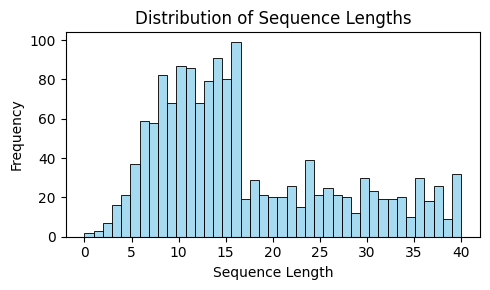

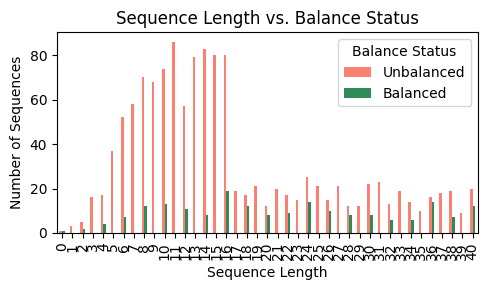

In [77]:
visualize_bracket_dataset(dataset_train)

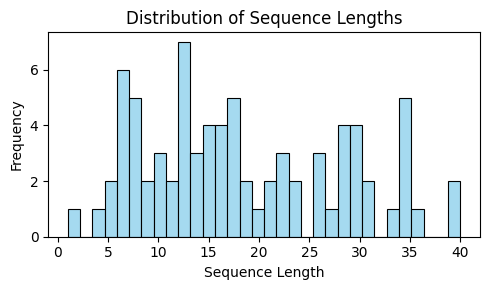

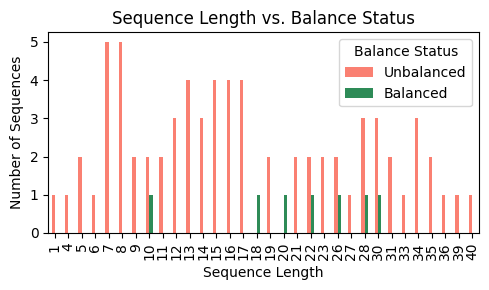

In [78]:
visualize_bracket_dataset(dataset_val)

# Training

In [79]:
import tqdm


def calculate_accuracy(
    preds: Float[torch.Tensor, "batch num_classes=2"],
    labels: Int[torch.Tensor, "batch"],
) -> float:
    """
    Calculate the overall accuracy of predictions.

    Args:
        preds (torch.Tensor): Predicted logits or probabilities, shape (batch_size, num_classes).
        labels (torch.Tensor): True labels, shape (batch_size).

    Returns:
        float: Overall accuracy.
    """
    _, pred_classes = torch.max(preds, dim=1)
    correct = pred_classes == labels
    return correct.float().mean().item()


def train_one_epoch(
    model: transformer_lens.HookedTransformer,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    max_batches: int | None = None,
) -> tuple[float, float]:
    """
    Train the model for one epoch.

    Args:
        model (transformer_lens.HookedTransformer): The model to train.
        dataloader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        device (torch.device): Device to run the training on.
        max_batches (int | None): Maximum number of batches to process.

    Returns:
        tuple[float, float]: Average training loss and accuracy.
    """
    model.train()

    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0

    for batch_index, batch in tqdm.tqdm(enumerate(dataloader), desc="Training", leave=False):

        if max_batches is not None and batch_index >= max_batches:
            break

        _, labels, inputs = batch  # batch is (strs, isbal, toks)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs: Float[torch.Tensor, "batch seq num_classes=2"] = model(inputs)

        # note: this is because we throw away everything but the first position
        logits: Float[torch.Tensor, "batch num_classes=2"] = outputs[:, 0]

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        batch_size = inputs.size(0)
        total_samples += batch_size
        running_loss += loss.item() * batch_size

        # Calculate accuracy for this batch
        batch_acc = calculate_accuracy(logits, labels)
        running_acc += batch_acc * batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = running_acc / total_samples

    return epoch_loss, epoch_acc


def evaluate(
    model: transformer_lens.HookedTransformer,
    dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> tuple[float, float]:
    """
    Evaluate the model on the validation set.

    Args:
        model (transformer_lens.HookedTransformer): The model to evaluate.
        dataloader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the evaluation on.

    Returns:
        tuple[float, float]: Average validation loss and accuracy
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Evaluating", leave=False):

            _, labels, inputs = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs: Float[torch.Tensor, "batch seq num_classes=2"] = model(inputs)

            # note: this is because we throw away everything but the first position
            logits: Float[torch.Tensor, "batch num_classes=2"] = outputs[:, 0]
            loss = criterion(logits, labels)
            acc = calculate_accuracy(logits, labels)

            batch_size = inputs.size(0)
            total_samples += batch_size
            running_loss += loss.item() * batch_size
            running_acc += acc * batch_size

    # Calculate epoch metrics
    epoch_loss = running_loss / total_samples
    epoch_acc = running_acc / total_samples

    return epoch_loss, epoch_acc

In [80]:
import wandb


# === Helper Functions for Logging and Printing ===
def print_accuracy_metrics(acc: float, prefix: str = ""):
    """Print accuracy metrics for a given dataset."""
    print(f"{prefix}Overall Acc: {acc*100:.2f}%")
    # Note: Detailed per-class and per-length metrics are no longer available


def log_metrics_to_wandb(
    train_loss: float,
    train_acc: float,
    val_loss: float,
    val_acc: float,
    epoch: int,
) -> None:
    """Log metrics to wandb."""
    log_dict = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "epoch": epoch,
    }

    # Note: Per-class and per-length accuracies are no longer available

    wandb.log(log_dict)

## Overfit on small batch first

In [81]:
from dataclasses import dataclass


# note: you can directly use the wandb config!
@dataclass
class TrainConfig:
    num_epochs: int = 100
    batch_size: int = Constants.BATCH_SIZE
    learning_rate: float = 1e-4
    max_length: int = Constants.MAX_SAMPLE_SIZE_TRAIN
    eval_every_n_epochs: int = 10
    random_seed: int = 42
    max_batches_train: int | None = None


train_cfg = TrainConfig()

# Initialize wandb
wandb.init(project="balanced_brackets_classification_v2", config=dataclasses.asdict(train_cfg))

model_cfg = make_model_config()
model = create_model(cfg=model_cfg, tokenizer=tokenizer)

# === Define Loss Function and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=train_cfg.learning_rate)

# === Training Loop ===
for epoch in range(1, train_cfg.num_epochs + 1):

    train_loss, train_acc = train_one_epoch(
        model, dataloader_train, criterion, optimizer, device, train_cfg.max_batches_train
    )

    # Print training metrics
    print(
        f"[Epoch {epoch}/{train_cfg.num_epochs}] Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f}"
    )

    # Log every `eval_every_n_epochs` or at the end
    if (epoch % train_cfg.eval_every_n_epochs) == 0 or epoch == train_cfg.num_epochs:

        val_loss, val_acc = evaluate(model, dataloader_val, criterion, device)

        # Log metrics to wandb
        log_metrics_to_wandb(train_loss, train_acc, val_loss, val_acc, epoch)

        # Print validation metrics
        print(
            f"[Epoch {epoch}/{train_cfg.num_epochs}] Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}"
        )

# Finish the wandb run
wandb.finish()

Moving model to device:  mps


[Epoch 1/100] Train Loss: 0.431319, Train Acc: 0.862986


[Epoch 2/100] Train Loss: 0.374775, Train Acc: 0.869802


[Epoch 3/100] Train Loss: 0.365014, Train Acc: 0.869802


[Epoch 4/100] Train Loss: 0.351916, Train Acc: 0.869802


[Epoch 5/100] Train Loss: 0.332239, Train Acc: 0.869802


[Epoch 6/100] Train Loss: 0.299871, Train Acc: 0.869802


[Epoch 7/100] Train Loss: 0.265744, Train Acc: 0.870484


[Epoch 8/100] Train Loss: 0.243516, Train Acc: 0.877301


[Epoch 9/100] Train Loss: 0.220978, Train Acc: 0.883436


[Epoch 10/100] Train Loss: 0.203112, Train Acc: 0.901159


[Epoch 10/100] Val Loss: 0.235681, Val Acc: 0.897436


[Epoch 11/100] Train Loss: 0.179563, Train Acc: 0.912747


[Epoch 12/100] Train Loss: 0.157288, Train Acc: 0.929789


[Epoch 13/100] Train Loss: 0.139685, Train Acc: 0.940014


[Epoch 14/100] Train Loss: 0.129068, Train Acc: 0.953647


[Epoch 15/100] Train Loss: 0.107235, Train Acc: 0.958419


[Epoch 16/100] Train Loss: 0.094964, Train Acc: 0.962509


[Epoch 17/100] Train Loss: 0.071668, Train Acc: 0.978868


[Epoch 18/100] Train Loss: 0.062635, Train Acc: 0.977505


[Epoch 19/100] Train Loss: 0.054912, Train Acc: 0.980232


[Epoch 20/100] Train Loss: 0.077842, Train Acc: 0.969325


[Epoch 20/100] Val Loss: 0.117826, Val Acc: 0.935897


[Epoch 21/100] Train Loss: 0.062709, Train Acc: 0.978187


[Epoch 22/100] Train Loss: 0.036445, Train Acc: 0.990457


[Epoch 23/100] Train Loss: 0.028820, Train Acc: 0.993183


[Epoch 24/100] Train Loss: 0.025296, Train Acc: 0.993183


[Epoch 25/100] Train Loss: 0.020547, Train Acc: 0.993865


[Epoch 26/100] Train Loss: 0.020548, Train Acc: 0.993183


[Epoch 27/100] Train Loss: 0.016760, Train Acc: 0.995910


[Epoch 28/100] Train Loss: 0.023653, Train Acc: 0.991820


[Epoch 29/100] Train Loss: 0.040273, Train Acc: 0.982958


[Epoch 30/100] Train Loss: 0.020029, Train Acc: 0.994547


[Epoch 30/100] Val Loss: 0.046933, Val Acc: 0.974359


[Epoch 31/100] Train Loss: 0.016808, Train Acc: 0.994547


[Epoch 32/100] Train Loss: 0.035318, Train Acc: 0.985003


[Epoch 33/100] Train Loss: 0.055008, Train Acc: 0.979550


[Epoch 34/100] Train Loss: 0.032541, Train Acc: 0.987048


[Epoch 35/100] Train Loss: 0.018251, Train Acc: 0.994547


[Epoch 36/100] Train Loss: 0.010990, Train Acc: 0.996592


[Epoch 37/100] Train Loss: 0.008266, Train Acc: 0.997273


[Epoch 38/100] Train Loss: 0.006986, Train Acc: 0.997273


[Epoch 39/100] Train Loss: 0.007605, Train Acc: 0.997955


[Epoch 40/100] Train Loss: 0.005981, Train Acc: 0.998637


[Epoch 40/100] Val Loss: 0.033902, Val Acc: 0.987179


[Epoch 41/100] Train Loss: 0.004964, Train Acc: 0.997955


[Epoch 42/100] Train Loss: 0.005511, Train Acc: 0.997955


[Epoch 43/100] Train Loss: 0.004987, Train Acc: 0.999318


[Epoch 44/100] Train Loss: 0.003991, Train Acc: 0.999318


[Epoch 45/100] Train Loss: 0.003763, Train Acc: 0.999318


[Epoch 46/100] Train Loss: 0.003238, Train Acc: 0.999318


[Epoch 47/100] Train Loss: 0.003103, Train Acc: 0.999318


[Epoch 48/100] Train Loss: 0.002799, Train Acc: 0.999318


[Epoch 49/100] Train Loss: 0.003025, Train Acc: 0.998637


[Epoch 50/100] Train Loss: 0.002598, Train Acc: 0.999318


[Epoch 50/100] Val Loss: 0.037580, Val Acc: 0.987179


[Epoch 51/100] Train Loss: 0.002549, Train Acc: 0.998637


[Epoch 52/100] Train Loss: 0.002382, Train Acc: 0.998637


[Epoch 53/100] Train Loss: 0.002305, Train Acc: 0.998637


[Epoch 54/100] Train Loss: 0.002242, Train Acc: 0.999318


[Epoch 55/100] Train Loss: 0.002149, Train Acc: 0.998637


[Epoch 56/100] Train Loss: 0.002143, Train Acc: 0.999318


[Epoch 57/100] Train Loss: 0.002043, Train Acc: 0.999318


[Epoch 58/100] Train Loss: 0.001997, Train Acc: 0.999318


[Epoch 59/100] Train Loss: 0.001933, Train Acc: 0.998637


[Epoch 60/100] Train Loss: 0.001954, Train Acc: 0.999318


[Epoch 60/100] Val Loss: 0.033372, Val Acc: 0.974359


[Epoch 61/100] Train Loss: 0.001944, Train Acc: 0.998637


[Epoch 62/100] Train Loss: 0.001871, Train Acc: 0.999318


[Epoch 63/100] Train Loss: 0.001849, Train Acc: 0.998637


[Epoch 64/100] Train Loss: 0.001819, Train Acc: 0.998637


[Epoch 65/100] Train Loss: 0.001796, Train Acc: 0.998637


[Epoch 66/100] Train Loss: 0.001719, Train Acc: 0.999318


[Epoch 67/100] Train Loss: 0.001733, Train Acc: 0.998637


[Epoch 68/100] Train Loss: 0.001700, Train Acc: 0.999318


[Epoch 69/100] Train Loss: 0.001692, Train Acc: 0.999318


[Epoch 70/100] Train Loss: 0.001631, Train Acc: 0.998637


[Epoch 70/100] Val Loss: 0.022786, Val Acc: 0.987179


[Epoch 71/100] Train Loss: 0.001599, Train Acc: 0.999318


[Epoch 72/100] Train Loss: 0.001583, Train Acc: 0.998637


[Epoch 73/100] Train Loss: 0.001593, Train Acc: 0.998637


[Epoch 74/100] Train Loss: 0.001636, Train Acc: 0.998637


[Epoch 75/100] Train Loss: 0.001581, Train Acc: 0.999318


[Epoch 76/100] Train Loss: 0.001546, Train Acc: 0.998637


[Epoch 77/100] Train Loss: 0.001545, Train Acc: 0.998637


[Epoch 78/100] Train Loss: 0.001523, Train Acc: 0.999318


[Epoch 79/100] Train Loss: 0.001575, Train Acc: 0.999318


[Epoch 80/100] Train Loss: 0.001589, Train Acc: 0.998637


[Epoch 80/100] Val Loss: 0.023299, Val Acc: 0.987179


[Epoch 81/100] Train Loss: 0.001544, Train Acc: 0.998637


[Epoch 82/100] Train Loss: 0.001429, Train Acc: 0.999318


[Epoch 83/100] Train Loss: 0.001441, Train Acc: 0.999318


[Epoch 84/100] Train Loss: 0.001473, Train Acc: 0.999318


[Epoch 85/100] Train Loss: 0.001432, Train Acc: 0.999318


[Epoch 86/100] Train Loss: 0.001397, Train Acc: 0.998637


[Epoch 87/100] Train Loss: 0.001448, Train Acc: 0.998637


[Epoch 88/100] Train Loss: 0.001453, Train Acc: 0.998637


[Epoch 89/100] Train Loss: 0.001395, Train Acc: 0.999318


[Epoch 90/100] Train Loss: 0.001430, Train Acc: 0.999318


[Epoch 90/100] Val Loss: 0.022279, Val Acc: 0.987179


[Epoch 91/100] Train Loss: 0.001412, Train Acc: 0.998637


[Epoch 92/100] Train Loss: 0.001335, Train Acc: 0.999318


[Epoch 93/100] Train Loss: 0.001403, Train Acc: 0.998637


[Epoch 94/100] Train Loss: 0.001435, Train Acc: 0.998637


[Epoch 95/100] Train Loss: 0.001403, Train Acc: 0.999318


[Epoch 96/100] Train Loss: 0.001393, Train Acc: 0.998637


[Epoch 97/100] Train Loss: 0.001363, Train Acc: 0.998637


[Epoch 98/100] Train Loss: 0.001425, Train Acc: 0.998637


[Epoch 99/100] Train Loss: 0.001326, Train Acc: 0.999318


[Epoch 100/100] Train Loss: 0.001387, Train Acc: 0.999318


[Epoch 100/100] Val Loss: 0.020443, Val Acc: 0.987179


In [99]:
# switch model to eval mode now that done training
model.eval()

print("Done training")

Done training


## Load Test Dataset

In [83]:
"""
Each training example consists of [start], up to 40 parens, [end], and then as many [pad] as necessary.

In the dataset we're using, half the sequences are balanced, and half are unbalanced. Having an equal distribution is on purpose to make it easier for the model.
"""

import pathlib
import json

bracket_data_filepath = pathlib.Path(
    "gpt_from_scratch/ARENA_3.0/"
    "chapter1_transformer_interp/exercises/"
    "part51_balanced_bracket_classifier/brackets_data.json"
).resolve()

assert bracket_data_filepath.exists()

N_SAMPLES = 5000
with open(bracket_data_filepath, "rt") as file:
    data_tuples: tuple[str, bool] = json.load(file)
    print(f"loaded {len(data_tuples)} examples")

assert isinstance(data_tuples, list)

data_tuples = data_tuples[:N_SAMPLES]
data = BracketsDataset(data_tuples).to_device(device)
data_mini = BracketsDataset(data_tuples[:100]).to_device(device)

loaded 100000 examples


# Loading The Model

We'll load their model first, so we're sure we're not doing the analysis wrong

> [!NOTE] Concretely there's did learn a very different algorithm from mine

In [167]:
cfg = make_model_config()
model = transformer_lens.HookedTransformer(cfg).eval()

model_filepath = bracket_data_filepath.parent / "brackets_model_state_dict.pt"

assert model_filepath.exists()

state_dict = torch.load(model_filepath, map_location=device)
model.load_state_dict(state_dict)

model = model.to(device)

# add hooks for dealing with padding horror
model.reset_hooks(including_permanent=True)
model = add_perma_hooks_to_mask_pad_tokens(model, tokenizer.PAD_TOKEN)

Moving model to device:  mps


/var/folders/g6/72q2lnk54yz_3sxkj9p0j6rc0000gn/T/ipykernel_35392/1518326916.py:8: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [168]:
# Define and tokenize examples
examples = ["()()", "(())", "))((", "()", "((()()()()))", "(()()()(()(())()", "()(()(((())())()))"]
labels = [True, True, False, True, True, False, True]
toks = tokenizer.tokenize(examples)

# Get output logits for the 0th sequence position (i.e. the [start] token)
logits = model(toks)[:, 0]

# Get the probabilities via softmax, then get the balanced probability (which is the second element)
prob_balanced = logits.softmax(-1)[:, 1]

# Display output
print(
    "Model confidence:\n"
    + "\n".join(
        [
            f"{ex:18} : {prob:<8.4%} : label={int(label)}"
            for ex, prob, label in zip(examples, prob_balanced, labels)
        ]
    )
)

Model confidence:
()()               : 99.9986% : label=1
(())               : 99.9989% : label=1
))((               : 0.0005%  : label=0
()                 : 99.9987% : label=1
((()()()()))       : 99.9987% : label=1
(()()()(()(())()   : 0.0006%  : label=0
()(()(((())())())) : 99.9982% : label=1


In [169]:
def run_model_on_data(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
    batch_size: int = 200,
) -> Float[torch.Tensor, "batch 2"]:
    """Return probability that each example is balanced"""
    all_logits = []
    for i in tqdm.tqdm(range(0, len(data.strs), batch_size)):
        toks = data.toks[i : i + batch_size]
        logits = model(toks)[:, 0]
        all_logits.append(logits)
    all_logits = torch.cat(all_logits)
    assert all_logits.shape == (len(data), 2)
    return all_logits


test_set = data
n_correct = (run_model_on_data(model, test_set).argmax(-1).bool() == test_set.isbal).sum()
print(f"\nModel got {n_correct} out of {len(data)} training examples correct!")

100%|██████████| 25/25 [00:00<00:00, 40.50it/s]


Model got 5000 out of 5000 training examples correct!


# The Model's Solution

At each position i, the model looks at the slice starting at the current position and going to the end: seq[i:]. It then computes (count of closed parens minus count of open parens) for that slice to generate the output at that position.

We'll refer to this output as the "elevation" at i, or equivalently the elevation for each suffix seq[i:].

The sequence is imbalanced if one or both of the following is true:
* elevation[0] is non-zero
* any(elevation < 0)
For English readers, it's natural to process the sequence from left to right and think about prefix slices seq[:i] instead of suffixes, but the model is bidirectional and has no idea what English is. This model happened to learn the equally valid solution of going right-to-left.

We'll spend today inspecting different parts of the network to try to get a first-pass understanding of how various layers implement this algorithm. However, we'll also see that neural networks are complicated, even those trained for simple tasks, and we'll only be able to explore a minority of the pieces of the puzzle.

In [170]:
def is_balanced_vectorized(tokens: Float[torch.Tensor, "seq_len"]) -> bool:
    """
    Return True if the parens are balanced.

    tokens is a vector which has start/pad/end indices (0/1/2) as well as left/right brackets (3/4)
    """
    # Convert start/end/padding tokens to zero, and left/right brackets to +1/-1
    table = torch.tensor([0, 0, 0, 1, -1])
    change = table[tokens]

    # Get altitude by taking cumulative sum (going from the right)
    altitude = torch.cumsum(change, -1)

    # Check that the total elevation is zero
    no_total_elevation_failure = altitude[-1] == 0

    # and that there are no negative altitudes
    no_negative_failure = altitude.min() >= 0

    return no_total_elevation_failure & no_negative_failure

## LayerNorm

Layernorm isn't actually linear. It's a combination of a nonlinear function (subtracting mean and dividing by std dev) with a linear one (a learned affine transformation).

However, in this case it turns out to be a decent approximation to use a linear fit. 

**The reason we've included layernorm in these exercises is to give you an idea of how nonlinear functions can complicate our analysis, and some simple hacky ways that we can deal with them.**

When applying this kind of analysis to LLMs, it's sometimes harder to abstract away layernorm as just a linear transformation. 
* For instance, many large transformers use layernorm to "clear" parts of their residual stream, e.g.
  * they learn a feature 100x as large as everything else and use it with layer norm to clear the residual stream of everything but that element. 
* Clearly, this kind of behaviour is not well-modelled by a linear fit.

In [171]:
# NOTE: THIS IS LIKE DOING IOI APPROACH OF CORRECT VS INCORRECT LOGIT DIFFERENCE DIR
def get_post_final_ln_dir(
    model: transformer_lens.HookedTransformer,
) -> Float[torch.Tensor, "d_model"]:
    """
    Returns the direction in which final_ln_output[0, :] should point to maximize P(unbalanced)
    """
    return model.W_U[:, 0] - model.W_U[:, 1]

### Seeing How Good Of a Linear Fit We Can Get For LayerNorm

tldr: Here we're fitting the input activations to the output activations of the layer norm.

In [172]:
import sklearn.linear_model


# Define a function to retrieve activations from the model using hooks
def get_activations(
    model: transformer_lens.HookedTransformer,
    toks: Int[torch.Tensor, "batch seq"],
    names: list[str],
) -> transformer_lens.ActivationCache:
    """Uses hooks to return activations from the model, in the form of an ActivationCache."""
    # Ensure names_list is always a list, even if a single name is provided
    names_list = [names] if isinstance(names, str) else names
    # Run the model with hooks to capture specified activations
    _, cache = model.run_with_cache(
        toks,
        return_type=None,
        names_filter=lambda name: name in names_list,  # only store activations in this list
    )
    # Return the captured activations
    return cache


# Define a helper function to get a single activation by name
def get_activation(
    model: transformer_lens.HookedTransformer,
    toks: Int[torch.Tensor, "batch seq"],
    name: str,
):
    """Gets a single activation."""
    # Retrieve activations and extract the one specified by 'name'
    cache = get_activations(model, toks, [name])
    return cache[name]


# Define a function to get the names of hooks around a specific layer normalization
def get_layernorm_hook_names(layernorm: nn.Module) -> tuple[str, str]:
    """
    Returns the names of the hooks immediately before and after a given layernorm.

    Example:
        model.final_ln -> ("blocks.2.hook_resid_post", "ln_final.hook_normalized")
    """
    # Check if the layernorm is the final layer normalization in the model
    if layernorm.name == "ln_final":
        # Define the input hook name based on the final block
        input_hook_name = transformer_lens.utils.get_act_name("resid_post", 2)
        # Define the output hook name for the final layer normalization
        output_hook_name = "ln_final.hook_normalized"
    else:
        # Split the layernorm name to extract layer and normalization part
        layer, ln = layernorm.name.split(".")[1:]
        # Determine the input hook name based on whether it's the first or middle layernorm
        input_hook_name = transformer_lens.utils.get_act_name(
            "resid_pre" if ln == "ln1" else "resid_mid", layer
        )
        # Determine the output hook name for the normalized activations
        output_hook_name = transformer_lens.utils.get_act_name("normalized", layer, ln)

    # Return the input and output hook names as a tuple
    return input_hook_name, output_hook_name


# Define a type alias for R-squared values from linear regression
# This represents the proportion of variance explained by the model
R2Float = float


# Define a function to fit a linear model to the layer normalization activations
def get_ln_fit(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
    layernorm: nn.Module,
    seq_pos: Optional[int] = None,
) -> tuple[sklearn.linear_model.LinearRegression, R2Float]:
    """
    Fits a linear regression, where the inputs are the values just before the layernorm given by the
    input argument `layernorm`, and the values to predict are the layernorm's outputs.

    Fit the inputs to the outputs of layernorm

    if `seq_pos` is None, find best fit aggregated over all sequence positions. Otherwise, fit only
    for the activations at `seq_pos`.

    Returns: A tuple of a (fitted) sklearn LinearRegression object and the r^2 of the fit.
    """
    # Get the names of the hooks before and after the specified layernorm
    input_hook_name, output_hook_name = get_layernorm_hook_names(layernorm)

    # Retrieve the activations for the input and output hooks
    activations_dict = get_activations(model, data.toks, [input_hook_name, output_hook_name])

    # Convert the input activations to a NumPy array for regression
    inputs = transformer_lens.utils.to_numpy(activations_dict[input_hook_name])

    # Convert the output activations to a NumPy array for regression
    outputs = transformer_lens.utils.to_numpy(activations_dict[output_hook_name])

    # Check if a specific sequence position is specified
    if seq_pos is None:
        # If no position is specified, reshape the data to combine batch and sequence dimensions
        inputs = einops.rearrange(inputs, "batch seq d_model -> (batch seq) d_model")
        outputs = einops.rearrange(outputs, "batch seq d_model -> (batch seq) d_model")
    else:
        # If a position is specified, select activations only at that sequence position
        inputs = inputs[:, seq_pos, :]
        outputs = outputs[:, seq_pos, :]

    # Initialize and fit a linear regression model to predict outputs from inputs
    final_ln_fit = sklearn.linear_model.LinearRegression().fit(inputs, outputs)

    # Calculate the R-squared value to evaluate the fit quality
    r2 = final_ln_fit.score(inputs, outputs)

    # Return the fitted model and its R-squared score
    return (final_ln_fit, r2)


# Define a function to get the direction in the residual stream before the final layer norm that influences unbalanced classification
def get_pre_final_ln_dir(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
) -> Float[torch.Tensor, "d_model"]:
    """
    Returns the direction in residual stream (pre ln_final, at sequence position 0) which
    most points in the direction of making an unbalanced classification.
    """
    # Get the direction that maximizes the probability of classifying as unbalanced after the final layer norm
    post_final_ln_dir = get_post_final_ln_dir(model)

    # Fit a linear model to predict the final layer norm's outputs from its inputs at sequence position 0
    final_ln_fit = get_ln_fit(model, data, layernorm=model.ln_final, seq_pos=0)[0]
    # Convert the linear regression coefficients to a PyTorch tensor and move to the appropriate device
    final_ln_coefs = torch.from_numpy(final_ln_fit.coef_).to(device)

    # Compute the direction in the residual stream by projecting the post-layer-norm direction back through the linear fit
    return final_ln_coefs.T @ post_final_ln_dir

In [173]:
# r^2 for LN_final, at sequence position 0: 0.9643
_, r2 = get_ln_fit(model, data, layernorm=model.ln_final, seq_pos=0)
print(f"r^2 for LN_final, at sequence position 0: {r2:.4f}")

r^2 for LN_final, at sequence position 0: 0.9820


In [174]:
# r^2 for LN1, layer 1, over all sequence positions: 0.9886
_, r2 = get_ln_fit(model, data, layernorm=model.blocks[1].ln1, seq_pos=None)
print(f"r^2 for LN1, layer 1, over all sequence positions: {r2:.4f}")

r^2 for LN1, layer 1, over all sequence positions: 0.9753


## Writing the residual stream as a sum of terms

It's much more natural to think about the residual stream as a sum of terms, each one representing a different path through the model. 
* Here, we have ten components which write to the residual stream: 
  * the direct path (i.e. the embeddings)
  * two attention heads
  * one MLP on each of the three layers

We can write the residual stream as a sum of these terms.

**Once we do this, we can narrow in on the components who are making direct contributions to the classification**, 
* i.e. which are writing vectors to the residual stream which have a high dot product with the `pre_final_ln_dir` for `unbalanced brackets ` relative to `balanced brackets`

In order to answer this question, we need the following tools:

* A way to break down the **input to the LN** by **component**.
* A tool to identify a direction in the embedding space that causes the network to output 'unbalanced' **(we already have this)**

### Breaking down the residual stream by component

> It isn't very conceptually important; the hardest part is getting all the right activation names & rearranging / stacking the tensors in the correct way.

Hint:

Start by getting all the activation names in a list. 
* You will need `utils.get_act_name("result", layer)` to get the activation names for the `attention heads'` output
* `utils.get_act_name("mlp_out", layer)` to get the activation names for the `MLPs'` output

Once you've done this, and run the `get_activations` function, it's just a matter of doing some reshaping and stacking. 

* Your embedding and mlp activations will have shape `(batch, seq_pos, d_model)`
* while your attention activations will have shape `(batch, seq_pos, head_idx, d_model)`.

In [175]:
# Oh sweet this is literally a breakdown of the residual stream in terms of components

import enum


class ComponentIndex(enum.IntEnum):
    """
    Enum representing indices for different components of the model.

    This allows for more readable code when accessing specific components
    in the output tensor from get_out_by_components().
    """

    EMBEDDINGS = 0
    HEAD_0_0 = 1
    HEAD_0_1 = 2
    MLP_0 = 3
    HEAD_1_0 = 4
    HEAD_1_1 = 5
    MLP_1 = 6
    HEAD_2_0 = 7
    HEAD_2_1 = 8
    MLP_2 = 9


# Example usage:
# out_by_components[ComponentIndex.HEAD_1_0]


def get_out_by_components(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
) -> Float[torch.Tensor, "component batch seq_pos emb"]:
    """
    Computes a tensor of shape [10, dataset_size, seq_pos, emb] representing the output of the model's components when run on the data.
    The first dimension is  [embeddings, head 0.0, head 0.1, mlp 0, head 1.0, head 1.1, mlp 1, head 2.0, head 2.1, mlp 2].
    The embeddings are the sum of token and positional embeddings.
    """
    embedding_hook_names = ["hook_embed", "hook_pos_embed"]
    head_hook_names = [
        transformer_lens.utils.get_act_name("result", layer) for layer in range(model.cfg.n_layers)
    ]
    mlp_hook_names = [
        transformer_lens.utils.get_act_name("mlp_out", layer) for layer in range(model.cfg.n_layers)
    ]

    all_hook_names = embedding_hook_names + head_hook_names + mlp_hook_names
    activations = get_activations(model, data.toks, all_hook_names)

    out = (activations["hook_embed"] + activations["hook_pos_embed"]).unsqueeze(0)

    for head_hook_name, mlp_hook_name in zip(head_hook_names, mlp_hook_names):
        out = torch.concat(
            [
                out,
                einops.rearrange(
                    activations[head_hook_name], "batch seq heads emb -> heads batch seq emb"
                ),
                activations[mlp_hook_name].unsqueeze(0),
            ]
        )

    return out

In [176]:
# here we're literally reconstructing the residual stream input right before the final layer norm,
# since we've already broken down that part
#
# now we can dot it with the logit diff direction to see how much each component *directly* contributed to this dimension
#
# we're basically going off the intuition that it makes sense that model is using one dimension of the residual stream to represent how much it believes one particular classification
#
# note: this _is_ a simplification, in our case that's literally all the model is doing so it's likely and
#       we can falsfify it and also ensure that the model is not doing anything else

# note: we're adding the bias back in
biases = model.b_O.sum(0)
out_by_components = get_out_by_components(model, data)
summed_terms = out_by_components.sum(dim=0) + biases

final_ln_input_name, final_ln_output_name = get_layernorm_hook_names(model.ln_final)
final_ln_input = get_activation(model, data.toks, final_ln_input_name)

assert torch.allclose(summed_terms, final_ln_input, rtol=1e-4, atol=1e-4)

In [177]:
summed_terms.shape

torch.Size([5000, 42, 56])

In [178]:
final_ln_input.shape

torch.Size([5000, 42, 56])

## Which Components Matter?

To figure out which components are directly important for the the model's output being "unbalanced", we can see which components tend to output a vector to the position-0 residual stream with higher dot product in the unbalanced direction for actually unbalanced inputs.

The idea is that, if a component is important for correctly classifying unbalanced inputs, then its vector output when fed unbalanced bracket strings will have a higher dot product in the unbalanced direction than when it is fed balanced bracket strings.

In this section, we'll plot histograms of the dot product for each component. This will allow us to observe which components are significant.

### Compute output in unbalanced direction for each component

It's very important to conceptually understand what object you are computing here. The actual computation is just a few lines of code involving indexing and einsums.

In [179]:
# Get output by components, at sequence position 0 (which is used for classification)
#
# The [i, j]th element of this tensor should be:
#  - the dot product of
#    - the ith component's output
#    - with the unbalanced direction
#  - for the jth sequence in your dataset.
#
out_by_components: Float[torch.Tensor, "comp batch seq d_model"] = get_out_by_components(
    model,
    data,
)

out_by_components_seq0: Float[torch.Tensor, "comp batch d_model"] = out_by_components[:, :, 0, :]

print(f"{out_by_components_seq0.shape=}")

# Get the unbalanced direction for tensors being fed into the final layernorm
pre_final_ln_dir = get_pre_final_ln_dir(model, data)  # [d_model]

print(f"{pre_final_ln_dir.shape=}")

# Get the size of the contributions for each component
out_by_component_in_classification_dir: Float[torch.Tensor, "comp batch"] = einops.einsum(
    out_by_components_seq0,
    pre_final_ln_dir,
    "comp batch d_model, d_model -> comp batch",
)
print(f"{out_by_component_in_classification_dir.shape=}")

# Subtract the mean value for `balanced` to normalize it
#
# TODO(bschoen): I still don't quite understand this normalization, but do we do the same thing in IOI?
#
# subtract the mean for each component across all the balanced samples (you can use the boolean data.isbal as your index).
out_by_component_in_balanced_dir: Float[torch.Tensor, "comp batch_balanced"] = (
    out_by_component_in_classification_dir[:, data.isbal]
)
print(f"{out_by_component_in_balanced_dir.shape=}")

# take the mean along the batch dimension for each component
out_by_component_in_balanced_dir_mean: Float[torch.Tensor, "comp"] = einops.reduce(
    out_by_component_in_balanced_dir, "comp batch_balanced -> comp", reduction="mean"
)
print(f"{out_by_component_in_balanced_dir_mean.shape=}")

# expand the mean value for each component across the batch dimension (repeat for each batch)
#
# note: we do this for `1` and it gets broadcast
#
out_by_component_in_balanced_dir_mean_batch: Float[torch.Tensor, "comp 1"] = einops.repeat(
    out_by_component_in_balanced_dir_mean,
    "comp -> comp 1",
)
print(f"{out_by_component_in_balanced_dir_mean_batch.shape=}")

# to get the unbalanced direction, we just subtract the mean for each component across all the balanced samples
#
# NOTE: Calling it the "unbalanced direction" is confusing, it's more of the `logit_diff_dir`
#
# this is why we can look at it across all samples
#
# here we're normalizing it by the average value for each component
#
out_by_component_in_logit_diff_dir: Float[torch.Tensor, "comp batch"] = (
    out_by_component_in_classification_dir - out_by_component_in_balanced_dir_mean_batch
)
print(f"{out_by_component_in_logit_diff_dir.shape=}")

out_by_components_seq0.shape=torch.Size([10, 5000, 56])
pre_final_ln_dir.shape=torch.Size([56])
out_by_component_in_classification_dir.shape=torch.Size([10, 5000])
out_by_component_in_balanced_dir.shape=torch.Size([10, 2284])
out_by_component_in_balanced_dir_mean.shape=torch.Size([10])
out_by_component_in_balanced_dir_mean_batch.shape=torch.Size([10, 1])
out_by_component_in_logit_diff_dir.shape=torch.Size([10, 5000])


out_by_component_in_logit_diff_dir.shape=torch.Size([10, 5000])


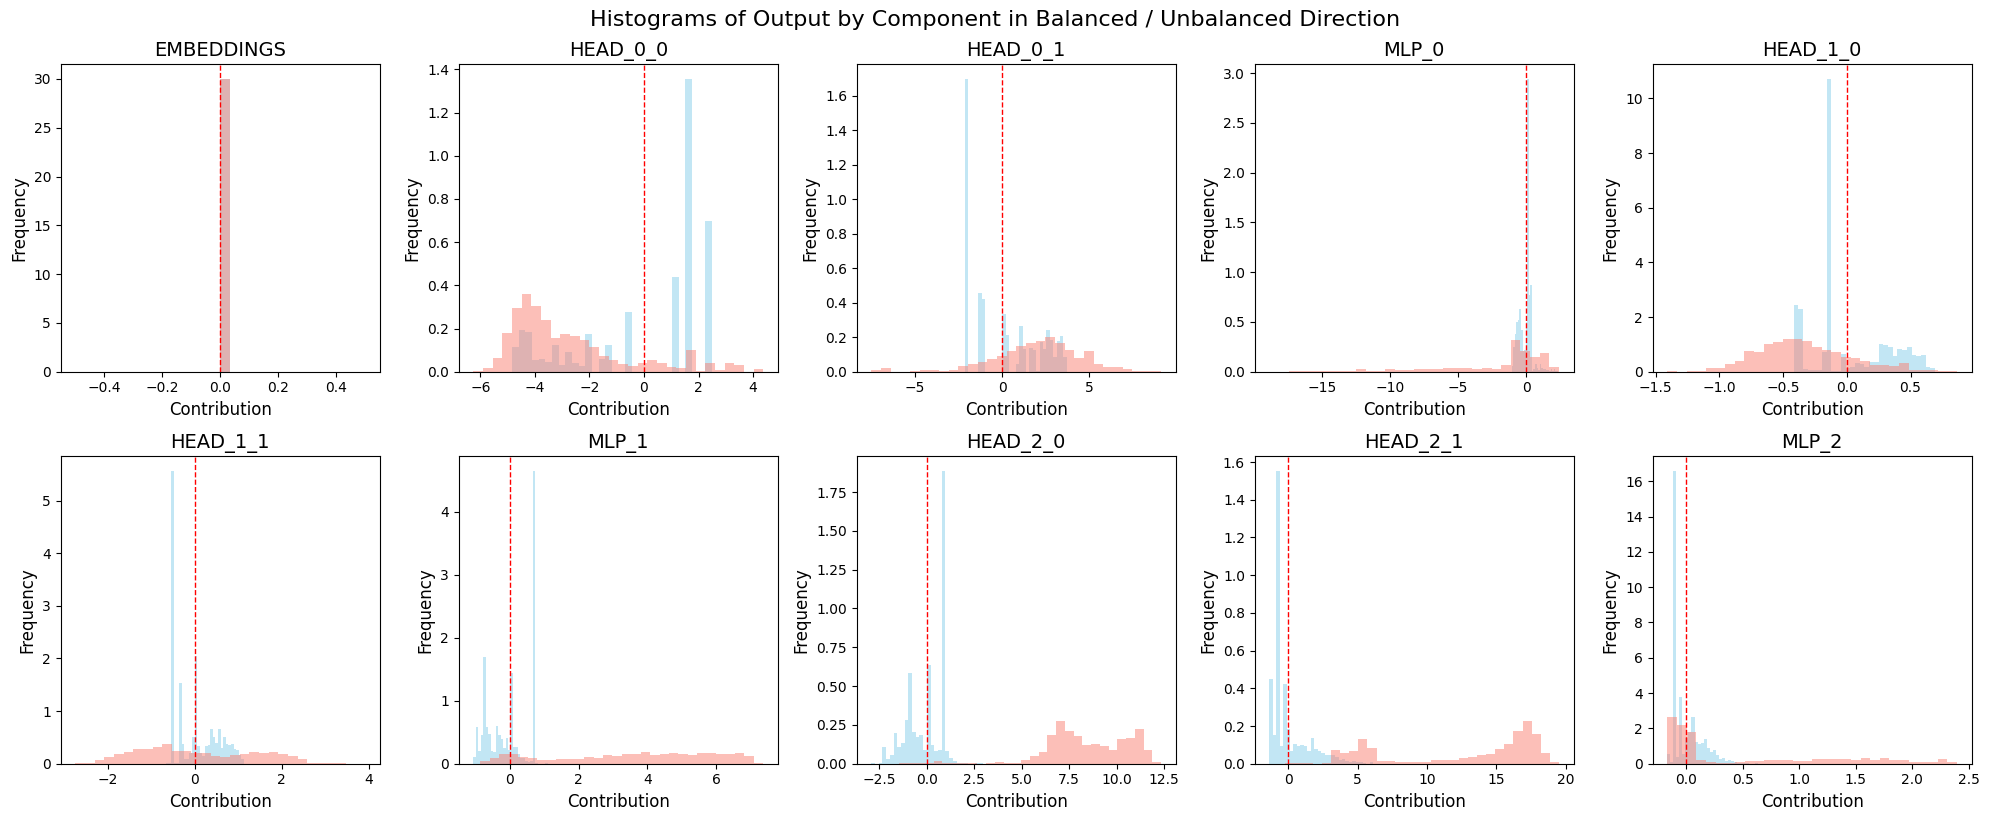

In [188]:
import matplotlib.pyplot as plt
import numpy as np


def plot_out_by_component_histograms(
    out_by_component_in_logit_diff_dir: Float[torch.Tensor, "comp batch"],
    data: BracketsDataset,
    bins: int = 100,
) -> None:

    print(f"{out_by_component_in_logit_diff_dir.shape=}")

    # Convert to NumPy array if it's a PyTorch tensor
    out_by_component_in_logit_diff_dir_np = transformer_lens.utils.to_numpy(
        out_by_component_in_logit_diff_dir
    )

    is_balanced_index = data.isbal.cpu().numpy()

    # Define the subplot grid dimensions (e.g., 2 rows x 5 columns for 10 components)
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8))
    axes = axes.flatten()  # Flatten to easily iterate over

    for component_index in ComponentIndex:
        ax = axes[component_index]
        component_data = out_by_component_in_logit_diff_dir_np[component_index]

        # Plot histogram
        ax.hist(
            component_data[is_balanced_index],
            bins=bins,
            color="skyblue",
            alpha=0.5,
            label="Balanced",
            density=True,
        )
        ax.hist(
            component_data[~is_balanced_index],
            bins=bins,
            color="salmon",
            alpha=0.5,
            label="Unbalanced",
            density=True,
        )

        # Set title and labels
        ax.set_title(f"{component_index.name}", fontsize=14)
        ax.set_xlabel("Contribution", fontsize=12)
        ax.set_ylabel("Frequency", fontsize=12)

        # Optionally, add a vertical line at zero to indicate the center
        ax.axvline(0, color="red", linestyle="dashed", linewidth=1)

    # If there are any unused subplots, hide them
    for j in range(len(ComponentIndex), nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(
        "Histograms of Output by Component in Balanced / Unbalanced Direction",
        fontsize=16,
        y=1.02,
    )
    plt.show()


plot_out_by_component_histograms(
    out_by_component_in_logit_diff_dir=out_by_component_in_logit_diff_dir.detach(),
    data=data,
    bins=30,
)

In [189]:
from gpt_from_scratch import plotly_utils

# give them all the same xaxis range
plotly_utils.hists_per_comp(out_by_component_in_logit_diff_dir, data, xaxis_range=[-10, 20])

In [190]:
import rich
import rich.table

table = rich.table.Table("Component", "Shape")

for component_index in ComponentIndex:

    shape = out_by_component_in_logit_diff_dir[component_index].shape

    table.add_row(component_index.name, str(shape))

rich.print(table)

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Component  ┃ Shape              ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ EMBEDDINGS │ torch.Size([5000]) │
│ HEAD_0_0   │ torch.Size([5000]) │
│ HEAD_0_1   │ torch.Size([5000]) │
│ MLP_0      │ torch.Size([5000]) │
│ HEAD_1_0   │ torch.Size([5000]) │
│ HEAD_1_1   │ torch.Size([5000]) │
│ MLP_1      │ torch.Size([5000]) │
│ HEAD_2_0   │ torch.Size([5000]) │
│ HEAD_2_1   │ torch.Size([5000]) │
│ MLP_2      │ torch.Size([5000]) │
└────────────┴────────────────────┘

### Look at components compared to each other

* Head 2_1 seems to detect `negative altitude (nowhere negative) failure`
* Head 2_0 seems to detect `total elevation failure`
* So neither one firing means `balanced`
* MLP probably converts that to a binary signal

Failure types:

`(N_SAMPLES,)` boolean vector that is true for sequences whose:

* `negative_failure` 
  * `elevation` (when reading from **right to left**) **ever** dips **negative**
  * i.e. **there's an open paren that is never closed.**
* `total_elevation_failure`
  * `elevation` is not exactly `0`
  * i.e. **an uneven numbers of open and close parens.**

Invidiual head component examples:

* `h20_in_unbalanced_dir`
  * This is an (N_SAMPLES,) float vector equal to head 2.0's contribution to the position-0 residual stream in the unbalanced direction, normalized by subtracting its average unbalancedness contribution to this stream over balanced sequences.
* `h21_in_unbalanced_dir`
  * Same as above but head 2.1

In [191]:
from jaxtyping import Bool


# essentially look for the two features we already expect
#
def is_balanced_vectorized_return_both(
    toks: Float[torch.Tensor, "batch seq"]
) -> tuple[Bool[torch.Tensor, "batch"], Bool[torch.Tensor, "batch"]]:

    table = torch.tensor([0, 0, 0, 1, -1]).to(device)
    change = table[toks.to(device)].flip(-1)
    altitude = torch.cumsum(change, -1)
    total_elevation_failure = altitude[:, -1] != 0
    negative_failure = altitude.max(-1).values > 0
    return total_elevation_failure, negative_failure

In [208]:
total_elevation_failure, negative_failure = is_balanced_vectorized_return_both(data.toks)

# look at two particular heads
component_index_a = ComponentIndex.HEAD_2_0
component_index_b = ComponentIndex.HEAD_2_1

component_a_in_unbalanced_dir = out_by_component_in_logit_diff_dir[component_index_a]
component_b_in_unbalanced_dir = out_by_component_in_logit_diff_dir[component_index_b]

failure_types_dict = {
    "both failures": negative_failure & total_elevation_failure,
    "just neg failure": negative_failure & ~total_elevation_failure,
    "just total elevation failure": ~negative_failure & total_elevation_failure,
    "balanced": ~negative_failure & ~total_elevation_failure,
}

plotly_utils.plot_failure_types_scatter(
    component_a_in_unbalanced_dir,
    component_b_in_unbalanced_dir,
    failure_types_dict,
    data,
)

#### Plot first layer contribution

* Interestingly it looks like MLP_0 is doing something in the opposite direction of HEAD_0_1

In [209]:
for component_index in ComponentIndex:

    if component_index > ComponentIndex.MLP_0:
        continue

    component_in_unbalanced_dir = out_by_component_in_logit_diff_dir[component_index]

    plotly_utils.plot_contribution_vs_open_proportion(
        component_in_unbalanced_dir,
        f"{component_index.name} contribution vs proportion of open brackets '('",
        failure_types_dict,
        data,
    )

#### Plot the second layer contribution

* Head 1.1 seems to be separating out the `negative altitude` (can't balance) vs balanced
  * Using values further away from 0 
* Head 1.0 is trying to help do the same thing but to a lesser extent
* MLP_1 then finishes the job by making a clean binary feature for `negative altitude`

In [206]:
for component_index in ComponentIndex:

    if component_index < ComponentIndex.HEAD_1_0 or component_index > ComponentIndex.MLP_1:
        continue

    component_in_unbalanced_dir = out_by_component_in_logit_diff_dir[component_index]

    plotly_utils.plot_contribution_vs_open_proportion(
        component_in_unbalanced_dir,
        f"{component_index.name} contribution vs proportion of open brackets '('",
        failure_types_dict,
        data,
    )

#### Plot the third layer contribution

In [207]:
for component_index in ComponentIndex:

    if component_index < ComponentIndex.HEAD_2_0:
        continue

    component_in_unbalanced_dir = out_by_component_in_logit_diff_dir[component_index]

    plotly_utils.plot_contribution_vs_open_proportion(
        component_in_unbalanced_dir,
        f"{component_index.name} contribution vs proportion of open brackets '('",
        failure_types_dict,
        data,
    )

### Looking at an individual head

In [210]:
def get_attn_probs(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
    layer: int,
    head: int,
) -> Float[torch.Tensor, "batch seq_q seq_k"]:
    """
    Returns: (N_SAMPLES, max_seq_len, max_seq_len) tensor that sums to 1 over the last dimension.
    """
    hook_name = transformer_lens.utils.get_act_name("pattern", layer)
    cache = get_activations(model, data.toks, [hook_name])
    activation: Float[torch.Tensor, "batch head seq_q seq_k"] = cache[hook_name]
    return activation[:, head, :, :]

* You should see:
  * an average attention of around 0.5 on position 1
  * an average of about 0 for all other tokens. 

So 2.0 is just moving information:
* [from] `residual stream 1` 
* [to] `residual stream 0`

In other words:
 * `2.0` passes `residual stream 1` through its `W_OV` circuit (after `LayerNorming`, of course)
   * weighted by some amount which we'll pretend is constant

Importantly, this means that the necessary information for classification:
 * must **already have been stored** in `sequence position 1` **before this head**

In [213]:
# NOTE: So by classifying the data beforehand, we're basically looking at directly just those

attn_probs_20 = get_attn_probs(model, data, 2, 0)  # [batch seqQ seqK]
attn_probs_20_open_query0 = attn_probs_20[data.starts_open].mean(0)[0]

plotly_utils.bar(
    attn_probs_20_open_query0,
    title="Avg Attention Probabilities for query 0, first token '(', head 2.0",
    width=700,
)

TypeError: bar() got an unexpected keyword argument 'y_max'

### Identifying meaningful direction before this head

If we make the simplification that:
* the vector moved to `sequence position 0 by head 2.0` is just
  * `layernorm(x[1]) @ W_OV`
    * where `x[1]` is the vector in `the residual stream before head 2.0, at sequence position 1)`
* then we can do **the same kind of logit attribution we did before**.

Rather than decomposing:
* the input to the `final layernorm (at sequence position 0)` into the `sum of ten components` 
* and measuring their contribution in the `"pre final layernorm unbalanced direction"`, 
we can:
* decompose the `input to head 2.0 (at sequence position 1)`
* into the `sum of the seven components before head 2.0`
* and measure their contribution in the `"pre head 2.0 unbalanced direction"`.



In [214]:
def get_WOV(
    model: transformer_lens.HookedTransformer,
    layer: int,
    head: int,
) -> Float[torch.Tensor, "d_model d_model"]:
    """
    Returns the W_OV matrix for a particular layer and head.
    """
    return model.W_V[layer, head] @ model.W_O[layer, head]


def get_pre_20_dir(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
) -> Float[torch.Tensor, "d_model"]:
    """
    Returns the direction propagated back through the OV matrix of 2.0
    and then through the layernorm before the layer 2 attention heads.
    """
    W_OV = get_WOV(model, 2, 0)

    layer2_ln_fit, r2 = get_ln_fit(model, data, layernorm=model.blocks[2].ln1, seq_pos=1)
    layer2_ln_coefs = torch.from_numpy(layer2_ln_fit.coef_).to(device)

    pre_final_ln_dir = get_pre_final_ln_dir(model, data)

    return layer2_ln_coefs.T @ W_OV @ pre_final_ln_dir

* More interestingly, we can see that `mlp0` and especially `mlp1` are very important. 
* This makes sense -- one thing that `mlps` are especially capable of doing is:
  * turning more continuous features ('what proportion of characters in this input are open parens?')
  * into sharp discontinuous features ('is that proportion exactly 0.5?').

* `Head 1.1` also has some importance, although we will not be able to dig into this today.
  * It turns out that one of the main things it does is:
    * incorporate information about when there is a `negative elevation failure` into this `overall elevation branch`. 
    * This allows the heads to agree the prompt is `unbalanced` when it is obviously so
      * even if the overall count (`elevation`)of opens and closes would allow it to be balanced.


In [215]:
pre_layer2_outputs_seqpos1 = out_by_components[:-3, :, 1, :]

# again logit diff dir
out_by_component_in_pre_20_unbalanced_dir = einops.einsum(
    pre_layer2_outputs_seqpos1,
    get_pre_20_dir(model, data),
    "comp batch emb, emb -> comp batch",
)

# normalize
out_by_component_in_pre_20_unbalanced_dir -= out_by_component_in_pre_20_unbalanced_dir[
    :, data.isbal
].mean(-1, keepdim=True)

plotly_utils.hists_per_comp(out_by_component_in_pre_20_unbalanced_dir, data, xaxis_range=(-5, 12))

### Looking at the MLPs before this head

In order to get a better look at what `mlp0` and `mlp1` are doing more thoughly, we can look at their output as a function of the overall open-proportion of the bracket sequence.



In [216]:
plotly_utils.mlp_attribution_scatter(
    out_by_component_in_pre_20_unbalanced_dir,
    data,
    failure_types_dict,
)

#### Get MLP Output By Neuron

The function get_out_by_neuron should return the given MLP's output per neuron. In other words, the output has shape [batch, seq, neurons, d_model], where out[b, s, i] is the vector **...** and summing over i would give you the actual output of the MLP

> [!NOTE] We ignore `b_out` here because it isn't attributable to any specific neuron.

When you have this output, you can:
* use `get_out_by_neuron_in_20_dir` to calculate the output of each neuron in the unbalanced direction
* for the input to `head 2.0` at `sequence position 1`. 

> [!NOTE] We're only considering `sequence position 1`, because we've observed that `head 2.0` is mainly just copying info from `position 1` to `position 0`. 

This is why we've given you the `seq` argument in the `get_out_by_mlp_neuron` function, so you don't need to store more information than is necessary.

In [219]:
def get_out_by_mlp_neuron(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
    layer: int,
    seq: int | None = None,
) -> Float[torch.Tensor, "batch *seq neuron d_model"]:
    """
    If seq is None, then out[batch, seq, i, :] = f(x[batch, seq].T @ W_in[:, i] + b_in[i]) @ W_out[i, :],
    i.e. the vector which is written to the residual stream by the ith neuron (where x is the input to the
    residual stream (i.e. shape (batch, seq, d_model)).

    If seq is not None, then out[batch, i, :] = f(x[batch, seq].T @ W_in[:, i]) @ W_out[i, :], i.e. we just
    look at the sequence position given by argument seq.

    (Note, using * in jaxtyping indicates an optional dimension)
    """
    # Get the W_out matrix for this MLP
    W_out: Float[torch.Tensor, "neuron d_model"] = model.W_out[layer]

    # Get activations of the layer just after the activation function, i.e. this is f(x.T @ W_in)
    f_x_W_in: Float[torch.Tensor, "batch seq neuron"] = get_activation(
        model,
        data.toks,
        transformer_lens.utils.get_act_name("post", layer),
    )

    # f_x_W_in are activations, so they have batch and seq dimensions - this is where we index by seq if necessary
    if seq is not None:
        f_x_W_in: Float[torch.Tensor, "batch neuron"] = f_x_W_in[:, seq, :]

    # Calculate the output by neuron (i.e. so summing over the `neurons` dimension gives the output of the MLP)
    out: Float[torch.Tensor, "batch neuron d_model"] = einops.einsum(
        f_x_W_in,
        W_out,
        "... neuron, neuron d_model -> ... neuron d_model",
    )

    return out


def get_out_by_mlp_neuron_in_20_dir(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
    layer: int,
) -> Float[torch.Tensor, "batch neuron"]:
    """
    [b, s, i]th element is the contribution of the vector written by the ith neuron to the residual stream in the
    unbalanced direction (for the b-th element in the batch, and the s-th sequence position).

    In other words we need to take the vector produced by the `get_out_by_neuron` function, and project it onto the
    unbalanced direction for head 2.0 (at seq pos = 1).
    """
    # Get neuron output at sequence position 1
    out_by_neuron_seqpos1 = get_out_by_mlp_neuron(model, data, layer, seq=1)

    # For each neuron, project the vector it writes to residual stream along the pre-2.0 unbalanced direction
    return einops.einsum(
        out_by_neuron_seqpos1,
        get_pre_20_dir(model, data),
        "batch neuron d_model, d_model -> batch neuron",
    )


def get_out_by_mlp_neuron_in_20_dir_less_memory(
    model: transformer_lens.HookedTransformer,
    data: BracketsDataset,
    layer: int,
) -> Float[torch.Tensor, "batch neurons"]:
    """
    Has the same output as `get_out_by_neuron_in_20_dir`, but uses less memory (because it never stores
    the output vector of each neuron individually).
    """
    W_out: Float[torch.Tensor, "neurons d_model"] = model.W_out[layer]

    f_x_W_in: Float[torch.Tensor, "batch neurons"] = get_activation(
        model, data.toks, transformer_lens.utils.get_act_name("post", layer)
    )[:, 1, :]

    pre_20_dir = get_pre_20_dir(model, data)  # [d_model]

    # Multiply along the d_model dimension
    W_out_in_20_dir: Float[torch.Tensor, "neurons"] = W_out @ pre_20_dir

    # Multiply elementwise, over neurons (we're broadcasting along the batch dim)
    out_by_neuron_in_20_dir: Float[torch.Tensor, "batch neurons"] = f_x_W_in * W_out_in_20_dir

    return out_by_neuron_in_20_dir

### Interpreting the neurons

Now, try to identify several individual neurons that are especially important to 2.0.

For instance, you can do this by seeing which neurons have the largest difference between how much they write in our chosen direction on balanced and unbalanced sequences (especially unbalanced sequences beginning with an open paren).

Use the plot_neurons function to get a sense of what an individual neuron does on differen open-proportions.

One note: now that we are deep in the internals of the network, our assumption that a single direction captures most of the meaningful things going on in this overall-elevation circuit is highly questionable. This is especially true for using our 2.0 direction to analyize the output of mlp0, as one of the main ways this mlp has influence is through more indirect paths (such as mlp0 -> mlp1 -> 2.0) which are not the ones we chose our direction to capture. Thus, it is good to be aware that the intuitions you get about what different layers or neurons are doing are likely to be incomplete.

In [221]:
for layer in range(2):
    # Get neuron significances for head 2.0, sequence position #1 output
    mlp_neurons_in_20_dir = get_out_by_mlp_neuron_in_20_dir_less_memory(model, data, layer)
    neurons_in_unbalanced_dir = mlp_neurons_in_20_dir[data.starts_open, :]
    # Plot neurons' activations
    plotly_utils.plot_neurons(
        neurons_in_unbalanced_dir,
        model,
        data,
        failure_types_dict,
        layer,
        renderer="browser",
    )

### Understanding how the open-proportion is calculated - Head 0.0

#### 0.0 Attention Pattern

In [224]:
def get_q_and_k_for_given_input(
    model: transformer_lens.HookedTransformer,
    tokenizer: SimpleTokenizer,
    parens: str,
    layer: int,
) -> tuple[Float[torch.Tensor, "seq n_head d_model"], Float[torch.Tensor, "seq n_head d_model"]]:
    """
    Returns the queries and keys for the given parens string, for all attention heads in the given layer.
    """
    q_name = transformer_lens.utils.get_act_name("q", layer)
    k_name = transformer_lens.utils.get_act_name("k", layer)

    activations: transformer_lens.ActivationCache = get_activations(
        model=model,
        toks=tokenizer.tokenize(parens),
        names=[q_name, k_name],
    )

    q_activations_batch: Float[torch.Tensor, "batch seq n_head d_model"] = activations[q_name]
    k_activations_batch: Float[torch.Tensor, "batch seq n_head d_model"] = activations[k_name]

    q_activations: Float[torch.Tensor, "seq n_head d_model"] = q_activations_batch[0]
    k_activations: Float[torch.Tensor, "seq n_head d_model"] = k_activations_batch[0]

    return q_activations, k_activations

## Activation Patching / Causal Tracing

In [225]:
layer = 0

all_left_parens = "".join(["(" * 40])
all_right_parens = "".join([")" * 40])

model.reset_hooks()

q0_all_left, k0_all_left = get_q_and_k_for_given_input(model, tokenizer, all_left_parens, layer)
q0_all_right, k0_all_right = get_q_and_k_for_given_input(model, tokenizer, all_right_parens, layer)

k0_avg = (k0_all_left + k0_all_right) / 2

In [226]:
import IPython

In [228]:
import circuitsvis as cv

import IPython


# Define hook function to patch in q or k vectors
def hook_fn_patch_qk(
    value: Float[torch.Tensor, "batch seq head d_head"],
    hook: transformer_lens.hook_points.HookPoint,
    new_value: Float[torch.Tensor, "... seq d_head"],
    head_idx: int | None = None,
) -> None:
    if head_idx is not None:
        value[..., head_idx, :] = new_value[..., head_idx, :]
    else:
        value[...] = new_value[...]


# Define hook function to display attention patterns (using plotly)
def hook_fn_display_attn_patterns(
    pattern: Float[torch.Tensor, "batch heads seqQ seqK"],
    hook: transformer_lens.hook_points.HookPoint,
    head_idx: int = 0,
) -> None:

    avg_head_attn_pattern: Float[torch.Tensor, "seqQ seqK"] = pattern.mean(0)

    labels = ["[start]", *[f"{i+1}" for i in range(40)], "[end]"]

    IPython.display.display(
        cv.attention.attention_heads(
            tokens=labels,
            attention=avg_head_attn_pattern,
            attention_head_names=["0.0", "0.1"],
            max_value=avg_head_attn_pattern.max(),
            mask_upper_tri=False,  # use for bidirectional models
        )
    )

In [229]:
import functools

import transformer_lens as tl

# Run our model on left parens, but patch in the average key values for left vs right parens
# This is to give us a rough idea how the model behaves on average when the query is a left paren
model.run_with_hooks(
    tokenizer.tokenize(all_left_parens).to(device),
    return_type=None,
    fwd_hooks=[
        (tl.utils.get_act_name("k", layer), functools.partial(hook_fn_patch_qk, new_value=k0_avg)),
        (tl.utils.get_act_name("pattern", layer), hook_fn_display_attn_patterns),
    ],
)

In [230]:
def hook_fn_display_attn_patterns_for_single_query(
    pattern: Float[torch.Tensor, "batch heads seqQ seqK"],
    hook: tl.hook_points.HookPoint,
    head_idx: int = 0,
    query_idx: int = 1,
):
    plotly_utils.bar(
        tl.utils.to_numpy(pattern[:, head_idx, query_idx].mean(0)),
        title=f"Average attn probabilities on data at posn 1, with query token = '('",
        labels={"index": "Sequence position of key", "value": "Average attn over dataset"},
        height=500,
        width=800,
        yaxis_range=[0, 0.1],
    )

* This shows that the attention pattern is almost **exactly uniform** **over all tokens**. 
* This means the vector written to `sequence position 1` will be:
  * **approximately some scalar multiple of the vectors at each source position**,
  * transformed via the matrix `W_OV`.










In [232]:
data_len_40 = BracketsDataset.with_length(data_tuples, 40).to_device(device)

model.reset_hooks()
model.run_with_hooks(
    data_len_40.toks[data_len_40.isbal],
    return_type=None,
    fwd_hooks=[
        (tl.utils.get_act_name("q", 0), functools.partial(hook_fn_patch_qk, new_value=q0_all_left)),
        (tl.utils.get_act_name("pattern", 0), hook_fn_display_attn_patterns_for_single_query),
    ],
)

## Proposing a hypothesis

### The 0.0 OV circuit - Net Elevation

We want to understand what the `0.0 head` is writing to the residual stream. 

In particular, **we are looking for evidence that it is writing information about the `net elevation`**.

* If `head 0.0` is performing some kind of **aggregation**
  * then we should see that `v_L` and `v_R` are vectors pointing in **opposite directions**. 
* In other words:
  * `head 0.0` writes some scalar multiple of vector `v_L` to the residual stream
  * and we can extract the information `n_L - n_R` by projecting in the direction of this vector. 
  * The MLP can then take this information and process it in a nonlinear way
    * writing information about `whether the sequence is balanced` to the residual stream.









In [233]:
def embedding(
    model: tl.HookedTransformer,
    tokenizer: SimpleTokenizer,
    char: str,
) -> Float[torch.Tensor, "d_model"]:
    assert char in ("(", ")")
    idx = tokenizer.t_to_i[char]
    return model.W_E[idx]


W_OV = model.W_V[0, 0] @ model.W_O[0, 0]

layer0_ln_fit = get_ln_fit(model, data, layernorm=model.blocks[0].ln1, seq_pos=None)[0]

layer0_ln_coefs = torch.from_numpy(layer0_ln_fit.coef_).to(device)

v_L = embedding(model, tokenizer, "(") @ layer0_ln_coefs.T @ W_OV
v_R = embedding(model, tokenizer, ")") @ layer0_ln_coefs.T @ W_OV

print("Cosine similarity: ", torch.cosine_similarity(v_L, v_R, dim=0).item())

Cosine similarity:  -0.9974457025527954


#### cosine similarity of input directions

Another way to get this evidence

In [234]:
def cos_sim_with_MLP_weights(
    model: tl.HookedTransformer,
    v: Float[torch.Tensor, "d_model"],
    layer: int,
) -> Float[torch.Tensor, "d_mlp"]:
    """
    Returns a vector of length d_mlp, where the ith element is the cosine similarity between v and the
    ith in-direction of the MLP in layer `layer`.

    Recall that the in-direction of the MLPs are the columns of the W_in matrix.
    """
    v_unit = v / v.norm()
    W_in_unit = model.W_in[layer] / model.W_in[layer].norm(dim=0)

    return einops.einsum(v_unit, W_in_unit, "d_model, d_model d_mlp -> d_mlp")


def avg_squared_cos_sim(v: Float[torch.Tensor, "d_model"], n_samples: int = 1000) -> float:
    """
    Returns the average (over n_samples) cosine similarity between v and another randomly chosen vector.

    We can create random vectors from the standard N(0, I) distribution.
    """
    v2 = torch.randn(n_samples, v.shape[0]).to(device)
    v2 /= v2.norm(dim=1, keepdim=True)

    v1 = v / v.norm()

    return (v1 * v2).pow(2).sum(1).mean().item()

In [235]:
print("Avg squared cosine similarity of v_R with ...\n")

cos_sim_mlp0 = cos_sim_with_MLP_weights(model, v_R, 0)
print(f"...MLP input directions in layer 0:  {cos_sim_mlp0.pow(2).mean():.6f}")

cos_sim_mlp1 = cos_sim_with_MLP_weights(model, v_R, 1)
print(f"...MLP input directions in layer 1:  {cos_sim_mlp1.pow(2).mean():.6f}")

cos_sim_rand = avg_squared_cos_sim(v_R)
print(f"...random vectors of len = d_model:  {cos_sim_rand:.6f}")

Avg squared cosine similarity of v_R with ...

...MLP input directions in layer 0:  0.123868
...MLP input directions in layer 1:  0.130125
...random vectors of len = d_model:  0.017760


#### Summary

* `Head 0.0` pays attention uniformly to the suffix following each token, 
  * tallying up the amount of `open` and `close` parens that it sees
  * and writing that value to the residual stream. 
* This means that it writes a vector representing the `total elevation` to `residual stream 1`. 
  * The `MLPs` in `residual stream 1` then operate nonlinearly on this `tally`
    * writing vectors to the residual stream
    * that distinguish between the cases of
      * `zero total elevation`
      * `non-zero total elevation`
  * `Head 2.0` copies this signal to `residual stream 0`, 
    * where it then goes through the `classifier`
      * and leads to a classification as `unbalanced`
  * Our first-pass understanding of this behavior is complete.